# 앙상블 학습과 랜덤 포레스트

In [1]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__>= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes',labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID="ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID)
os.makedirs(IMAGES_PATH,exist_ok=True)



# 투표기반 분류기

In [2]:
heads_proba=0.51 # head probability
coin_tosses = (np.random.rand(10000,10)<heads_proba).astype(np.int32)
#10000번 던지는 것을 10번 수행한다.
#10000번의 실험읠 10번한다.

cumulative_heads_ratio = np.cumsum(coin_tosses,axis=0)/np.arange(1,10001).reshape(-1,1)
#cumsum은 차원에 따라서 값을 누적해준다. 행으로 누적하는듯.
# 0 1 0 .... 1
# ..
# ..
# 5100 5099 5100 5099
#이런식으로 수렴해 나가게 된다.

In [3]:
np.arange(1,10001).reshape(-1,1)

array([[    1],
       [    2],
       [    3],
       ...,
       [ 9998],
       [ 9999],
       [10000]])

In [4]:
np.cumsum(coin_tosses,axis=0)
#axis=0으로 아래방향

array([[   1,    0,    0, ...,    0,    0,    0],
       [   2,    0,    0, ...,    0,    1,    1],
       [   2,    1,    1, ...,    0,    1,    2],
       ...,
       [5113, 5114, 5067, ..., 5094, 5106, 5100],
       [5113, 5114, 5068, ..., 5095, 5107, 5101],
       [5113, 5115, 5068, ..., 5095, 5108, 5102]])

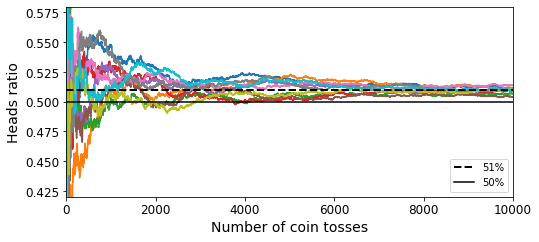

In [5]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio[:])
plt.plot([0,10000],[0.51,0.51],"k--",linewidth=2,label="51%")
plt.plot([0,10000],[0.5,0.5],"k-",label="50%")

plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

In [6]:
from scipy.stats import binom

#binom.pmf(0,1000,0.5)
# cdf는 누적값.
#1000 번을 던졌을 때 한번도 안나올 확률 (독립시행은 0.51)


print(1-binom.cdf(4999,10000,0.51))

0.9777976478701103


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y=make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='lbfgs',random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100,random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf=VotingClassifier(estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
                           voting='hard')
#각각 예측인 클래스에서 다수로 설정..

In [9]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


# 간접투표

In [11]:
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

#In Soft Method : Probability -> True
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

#Voting Method가 Soft.
#Hard는 다수결, Soft는 확률 계산을 한다는데....
voting_clf = VotingClassifier(estimators=[('lr',log_clf),('rf',rnd_clf),
                                         ('svc',svm_clf)],voting='soft')

In [12]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 배깅 앙상블

In [13]:
# bootstrapping aggregation
# bootstrap -> Sampling 하는 방법
# 견고해진다..?

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#여기서 기반 모델은 Decision Tree
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                           n_estimators=500,
                           max_samples=100,
                           bootstrap=True,
                           random_state=42)
#bootstrap이 뭔지 잘 모르겠음..
#max_sample이 1이면, 전체 샘플 크기와 똑같은 개수로 bootstrap을 수행한다..
#https://lucathree.github.io/ml/dl/pyml_guide_7/

bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,y_pred))
#0.904가 더 우수하다 단일 DecisionTree보다..

0.904


In [16]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train,y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test,y_pred_tree))

0.856


In [17]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5,2.45,-1,1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s,x2s)
    
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap=ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contour(x1,x2,y_pred,alpha=0.3, cmap=custom_cmap)
    
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1,x2,y_pred,cmap=custom_cmap2, alpha=0.8)
    
    plt.plot(X[:,0][y==0], X[:,1][y==0],"yo",alpha=alpha)
    plt.plot(X[:,0][y==1], X[:,1][y==1],"bs",alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$",fontsize=18)
    plt.ylabel(r"$x_2$",fontsize=18, rotation=0)

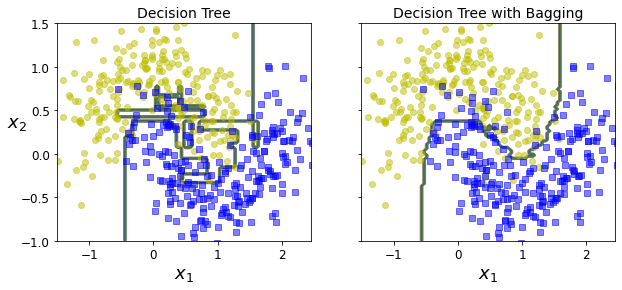

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf,X,y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf,X,y)
plt.title("Decision Tree with Bagging", fontsize=14)
plt.ylabel("")
plt.show()